# 準備

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

# 評価指標
import sys
sys.path.append('./evaluation')
from rmse import rmse
from recall5 import recall5
from profit import profit

# #エヴァリュエーション
# from sklearn.metrics import precision_score, recall_score, mean_squared_error

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

#保存
import pickle

In [2]:
#データを読み込む
n_uma_race_df = pd.read_pickle('../datasets/traindata/n_uma_race.pkl')
n_race_df = pd.read_pickle('../datasets/traindata/n_race.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

In [3]:
# 新しいグループを作成
n_uma_race_df['group'] = n_uma_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_uma_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_uma_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_uma_race_df['race_bango'].astype(int).astype(str)
n_race_df['group'] = n_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_race_df['race_bango'].astype(int).astype(str)
n_payout_df['group'] = n_payout_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_payout_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_payout_df['keibajo_code'].astype(int).astype(str) +"-"+  n_payout_df['race_bango'].astype(int).astype(str)

n_race_df_drop = n_race_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango'],axis=1)
n_payout_df_drop = n_payout_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango', 'toroku_tosu', 'shusso_tosu'],axis=1)

merged_df = pd.merge(n_uma_race_df, n_race_df_drop, on='group', how='left')
merged_df = pd.merge(merged_df, n_payout_df_drop, on='group', how='left')
merged_df['group'].nunique()

205318

In [4]:
merged_df['group'].unique()

array(['2023-916-46-1', '2023-916-46-2', '2023-916-46-3', ...,
       '2023-907-50-10', '2023-907-50-11', '2023-907-50-12'], dtype=object)

In [5]:
pd.set_option('display.max_columns', None)
merged_df.head(1)

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,umakigo_code,seibetsu_code,hinshu_code,moshoku_code,barei,tozai_shozoku_code,chokyoshi_code,banushi_code,banushimei,futan_juryo,blinker_shiyo_kubun,kishu_code,kishumei_ryakusho,kishu_minarai_code,bataiju,zogen_fugo,zogen_sa,ijo_kubun_code,nyusen_juni,kakutei_chakujun,dochaku_kubun,dochaku_tosu,soha_time,chakusa_code_1,chakusa_code_2,chakusa_code_3,corner_1,corner_2,corner_3,corner_4,tansho_odds,tansho_ninkijun,kakutoku_honshokin,kakutoku_fukashokin,kohan_4f,kohan_3f,aiteuma_joho_1,aiteuma_joho_2,aiteuma_joho_3,time_sa,record_koshin_kubun,kyakushitsu_hantei,group,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt,fuseiritsu_flag_sanrenpuku,tokubarai_flag_sanrenpuku,henkan_flag_sanrenpuku,haraimodoshi_sanrenpuku_1a,haraimodoshi_sanrenpuku_1b,haraimodoshi_sanrenpuku_1c
0,2023,916,46,13,1,1,1,1,2020106227,スターサファイア,0,1,1.0,3,3,3,5319,875800,ＪＰＮ技研,560.0,0,5300,葛山晃平,0,466.0,1,0.0,0,8,8,0,0,1359,4.0,NaN,NaN,9,9,9,9,899,8,0,0,0,411,2020105068フェイマスグローリ,0000000000,0000000000,50,0,0,2023-916-46-1,1,0,0,49,0,4,0,0,0,0,0,1400,24,0,4.000000e+51,0,1140,9,9,9,1,0,1.0,0.0,0.0,0.0,60809.0,210.0,1.0


# 前処理

In [6]:
merged_df['hutan_wariai'] = merged_df['futan_juryo'] / merged_df['bataiju']

In [7]:
def combine_sign_and_diff(row):
    if row['zogen_fugo'] == 2:
        return row['zogen_sa']
    elif row['zogen_fugo'] == 0:
        return -row['zogen_sa']
    else:
        return 0

merged_df['zogen_ryou'] = merged_df.apply(combine_sign_and_diff, axis=1)

In [8]:
merged_df = merged_df[merged_df['ijo_kubun_code'] == 0]
# 1	出走取消	取消	SCRATCHED	S

In [9]:
columns_to_convert = [
                    'kyori',
                    'grade_code',
                    'seibetsu_code',
                    'moshoku_code',
                    'barei',
                    'chokyoshi_code',
                    'banushi_code',
                    'kishu_code',
                    'kishu_minarai_code',
                    'kyoso_shubetsu_code',
                    'juryo_shubetsu_code',
                    'shusso_tosu',
                    'tenko_code',
                    'babajotai_code_dirt',
                    'hutan_wariai',
                    'zogen_ryou',
                    'track_code',
                    'keibajo_code'
                    ]

for column in columns_to_convert:
    merged_df[column].fillna(0, inplace=True)
    try:
        if merged_df[column].astype(float).apply(lambda x: x.is_integer()).all():
            merged_df[column] = merged_df[column].astype(int)
        else:
            merged_df[column] = merged_df[column].astype(float)
    except ValueError:
        merged_df[column] = merged_df[column].astype(float)

    print(f"{column} のデータ型: {merged_df[column].dtype}")

kyori のデータ型: int32
grade_code のデータ型: int32
seibetsu_code のデータ型: int32
moshoku_code のデータ型: int32
barei のデータ型: int32
chokyoshi_code のデータ型: int32
banushi_code のデータ型: int32
kishu_code のデータ型: int32
kishu_minarai_code のデータ型: int32
kyoso_shubetsu_code のデータ型: int32
juryo_shubetsu_code のデータ型: int32
shusso_tosu のデータ型: int32
tenko_code のデータ型: int32
babajotai_code_dirt のデータ型: int32
hutan_wariai のデータ型: float64
zogen_ryou のデータ型: int32
track_code のデータ型: int32
keibajo_code のデータ型: int32


In [10]:
merged_df[column].info()

<class 'pandas.core.series.Series'>
Index: 2017402 entries, 0 to 2042540
Series name: keibajo_code
Non-Null Count    Dtype
--------------    -----
2017402 non-null  int32
dtypes: int32(1)
memory usage: 23.1 MB


In [11]:
def invert_rankings(df, column_name='kakutei_chakujun'):
    """
    この関数はDataFrameの特定の列のランキングを逆転させます。
    - df: DataFrameオブジェクト
    - column_name: 逆転させる列の名前（デフォルトは 'kakutei_chakujun'）
    """
    max_rank = df.groupby('group')[column_name].transform('max')
    df[column_name] = max_rank - df[column_name] + 1
    
    return df

In [12]:
def modify_rankings(df, column_name='kakutei_chakujun'):
    """
    この関数はDataFrameの特定の列のランキングを修正します。
    - df: DataFrameオブジェクト
    - column_name: 修正する列の名前（デフォルトは 'kakutei_chakujun'）
    """
    conditions = [
        (df[column_name] == 1),
        (df[column_name] == 2),
        (df[column_name] == 3),
        (df[column_name] == 4),
        (df[column_name] == 5)
    ]
    
    values = [5, 4, 3, 2, 1]
    
    df['target'] = np.select(conditions, values, default=0)
    
    return df

In [13]:
merged_df = modify_rankings(merged_df)

In [14]:
merged_df['target'].value_counts()

target
0    999416
5    203842
4    203673
3    203665
2    203430
1    203376
Name: count, dtype: int64

# lightgbm.LGBMRanker

In [15]:
# 2010年から2019年のデータを学習データとして取得
train_data = merged_df[merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
test_data = merged_df[merged_df['kaisai_nen'].isin([2020, 2021, 2022])]

In [16]:
# ランキング学習のために必要な特徴量とターゲットを設定
features = [
            'seibetsu_code',
            'moshoku_code',
            'barei',
            'chokyoshi_code',
            'banushi_code',
            'kishu_code',
            'kishu_minarai_code',
            'kyoso_shubetsu_code',
            'juryo_shubetsu_code',
            'hutan_wariai',
            'zogen_ryou',
            ]

target = 'target'

In [17]:
categorical_features = ['seibetsu_code',
                        'moshoku_code',
                        'chokyoshi_code',
                        'banushi_code',
                        'kishu_code',
                        'kishu_minarai_code',
                        'kyoso_shubetsu_code',
                        'juryo_shubetsu_code',
                       ]

In [18]:
def ndcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    gain = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def mean_ndcg_score(y_true, y_score, groups, k=5):
    ndcgs = []
    idx_start = 0
    for group in groups:
        ndcgs.append(ndcg_score(y_true[idx_start:idx_start+group], y_score[idx_start:idx_start+group], k))
        idx_start += group
    return np.mean(ndcgs)

In [19]:
group_sizes = train_data.groupby('group').size()

def objective(trial):
    # Optuna parameters
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_at': 5,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': trial.suggest_int('verbose', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 10.0, log=True),  # L1正則化
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 10.0, log=True)  # L2正則化
    }
    
    gkf = GroupKFold(n_splits=5)
    ndcgs = []
    
    for train_index, valid_index in gkf.split(train_data, groups=train_data['group']):
        train_fold_data = train_data.iloc[train_index]
        valid_fold_data = train_data.iloc[valid_index]
        for feature in categorical_features:
            train_fold_data[feature] = train_fold_data[feature].astype('category')
            valid_fold_data[feature] = valid_fold_data[feature].astype('category')

        train_fold_group_sizes = train_fold_data.groupby('group').size().tolist()
        valid_fold_group_sizes = valid_fold_data.groupby('group').size().tolist()

        ranker = lgb.LGBMRanker(**params)
        ranker.fit(train_fold_data[features], train_fold_data[target], 
           group=train_fold_group_sizes, 
           eval_set=[(valid_fold_data[features], valid_fold_data[target])], 
           eval_group=[valid_fold_group_sizes], categorical_feature=categorical_features) 
        
        y_pred = ranker.predict(valid_fold_data[features])
        ndcg_value = mean_ndcg_score(valid_fold_data[target].values, y_pred, valid_fold_group_sizes)
        ndcgs.append(ndcg_value)
    
    return np.mean(ndcgs)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-10-19 02:26:44,277] A new study created in memory with name: no-name-fa9a72e1-ec26-45aa-a3e0-80f3c0e30131
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\en

[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.333961	valid_0's ndcg@2: 0.376228	valid_0's ndcg@3: 0.426608	valid_0's ndcg@4: 0.474211	valid_0's ndcg@5: 0.517989
[2]	valid_0's ndcg@1: 0.388114	valid_0's ndcg@2: 0.430007	valid_0's ndcg@3: 0.481162	valid_0's ndcg@4: 0.528136	valid_0's ndcg@5: 0.570327
[3]	valid_0's ndcg@1: 0.392713	valid_0's ndcg@2: 0.435343	valid_0's ndcg@3: 0.486376	valid_0's ndcg@4: 0.53236	valid_0's ndcg@5: 0.574142
[4]	valid_0's ndcg@1: 0.404814	valid_0's ndcg@2: 

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.334073	valid_0's ndcg@2: 0.377521	valid_0's ndcg@3: 0.427265	valid_0's ndcg@4: 0.474795	valid_0's ndcg@5: 0.518248
[2]	valid_0's ndcg@1: 0.389261	valid_0's ndcg@2: 0.433154	valid_0's ndcg@3: 0.483618	valid_0's ndcg@4: 0.53046	valid_0's ndcg@5: 0.572482
[3]	valid_0's ndcg@1: 0.396073	valid_0's ndcg@2: 0.439254	valid_0's ndcg@3: 0.488565	valid_0's ndcg@4: 0.534589	valid_0's ndcg@5: 0.576409
[4]	valid_0's ndcg@1: 0.407261	valid_0's ndcg@2: 

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.330978	valid_0's ndcg@2: 0.374964	valid_0's ndcg@3: 0.425399	valid_0's ndcg@4: 0.47333	valid_0's ndcg@5: 0.517276
[2]	valid_0's ndcg@1: 0.390958	valid_0's ndcg@2: 0.434454	valid_0's ndcg@3: 0.483884	valid_0's ndcg@4: 0.530867	valid_0's ndcg@5: 0.572819
[3]	valid_0's ndcg@1: 0.395453	valid_0's ndcg@2: 0.437928	valid_0's ndcg@3: 0.487947	valid_0's ndcg@4: 0.535215	valid_0's ndcg@5: 0.576804
[4]	valid_0's ndcg@1: 0.405715	valid_0's ndcg@2: 

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.332552	valid_0's ndcg@2: 0.376724	valid_0's ndcg@3: 0.42776	valid_0's ndcg@4: 0.475352	valid_0's ndcg@5: 0.520358
[2]	valid_0's ndcg@1: 0.386942	valid_0's ndcg@2: 0.431735	valid_0's ndcg@3: 0.482987	valid_0's ndcg@4: 0.530051	valid_0's ndcg@5: 0.572101
[3]	valid_0's ndcg@1: 0.395605	valid_0's ndcg@2: 0.439252	valid_0's ndcg@3: 0.489133	valid_0's ndcg@4: 0.535942	valid_0's ndcg@5: 0.577373
[4]	valid_0's ndcg@1: 0.406643	valid_0's ndcg@2: 

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6037893923464424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037893923464424
[LightGBM] [Warning] lambda_l1 is set=7.454901775090215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.454901775090215
[LightGBM] [Warning] lambda_l2 is set=2.4223716748411892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4223716748411892e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.339783	valid_0's ndcg@2: 0.38191	valid_0's ndcg@3: 0.432586	valid_0's ndcg@4: 0.479768	valid_0's ndcg@5: 0.523875
[2]	valid_0's ndcg@1: 0.391281	valid_0's ndcg@2: 0.434295	valid_0's ndcg@3: 0.484925	valid_0's ndcg@4: 0.531274	valid_0's ndcg@5: 0.573534
[3]	valid_0's ndcg@1: 0.396299	valid_0's ndcg@2: 0.438486	valid_0's ndcg@3: 0.488145	valid_0's ndcg@4: 0.535178	valid_0's ndcg@5: 0.576882
[4]	valid_0's ndcg@1: 0.409455	valid_0's ndcg@2: 

[I 2023-10-19 02:29:00,916] Trial 0 finished with value: 26.09493333526662 and parameters: {'num_leaves': 161, 'learning_rate': 0.010723453013096176, 'feature_fraction': 0.6037893923464424, 'bagging_freq': 7, 'verbose': 1, 'lambda_l1': 7.454901775090215, 'lambda_l2': 2.4223716748411892e-05}. Best is trial 0 with value: 26.09493333526662.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.294181	valid_0's ndcg@2: 0.339769	valid_0's ndcg@3: 0.390917	valid_0's ndcg@4: 0.43991	valid_0's ndcg@5: 0.485912
[2]	valid_0's ndcg@1: 0.376345	valid_0's ndcg@2: 0.420821	valid_0's ndcg@3: 0.473256	valid_0's ndcg@4: 0.521173	valid_0's ndcg@5: 0.563295
[3]	valid_0's ndcg@1: 0.378902	valid_0's ndcg@2: 0.420554	valid_0's ndcg@3: 0.471928	valid_0's ndcg@4: 0.519215	valid_0's ndcg@5: 0.56228
[4]	valid_0's ndcg@1: 0.38004	valid_0's ndcg@2: 0.

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.295165	valid_0's ndcg@2: 0.34145	valid_0's ndcg@3: 0.392943	valid_0's ndcg@4: 0.441203	valid_0's ndcg@5: 0.487396
[2]	valid_0's ndcg@1: 0.3781	valid_0's ndcg@2: 0.424294	valid_0's ndcg@3: 0.476202	valid_0's ndcg@4: 0.522976	valid_0's ndcg@5: 0.564879
[3]	valid_0's ndcg@1: 0.382856	valid_0's ndcg@2: 0.425853	valid_0's ndcg@3: 0.476466	valid_0's ndcg@4: 0.523252	valid_0's ndcg@5: 0.565139
[4]	valid_0's ndcg@1: 0.377234	valid_0's ndcg@2: 0.

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.297443	valid_0's ndcg@2: 0.34218	valid_0's ndcg@3: 0.392153	valid_0's ndcg@4: 0.441951	valid_0's ndcg@5: 0.487473
[2]	valid_0's ndcg@1: 0.382438	valid_0's ndcg@2: 0.424363	valid_0's ndcg@3: 0.475651	valid_0's ndcg@4: 0.523228	valid_0's ndcg@5: 0.565672
[3]	valid_0's ndcg@1: 0.385198	valid_0's ndcg@2: 0.42705	valid_0's ndcg@3: 0.476664	valid_0's ndcg@4: 0.523615	valid_0's ndcg@5: 0.565549
[4]	valid_0's ndcg@1: 0.378668	valid_0's ndcg@2: 0

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.300108	valid_0's ndcg@2: 0.346207	valid_0's ndcg@3: 0.395536	valid_0's ndcg@4: 0.444212	valid_0's ndcg@5: 0.489966
[2]	valid_0's ndcg@1: 0.380889	valid_0's ndcg@2: 0.425012	valid_0's ndcg@3: 0.475697	valid_0's ndcg@4: 0.524005	valid_0's ndcg@5: 0.566785
[3]	valid_0's ndcg@1: 0.383793	valid_0's ndcg@2: 0.426125	valid_0's ndcg@3: 0.476315	valid_0's ndcg@4: 0.524228	valid_0's ndcg@5: 0.566036
[4]	valid_0's ndcg@1: 0.377547	valid_0's ndcg@2:

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.42612362420567623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42612362420567623
[LightGBM] [Warning] lambda_l1 is set=3.494722710465725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.494722710465725
[LightGBM] [Warning] lambda_l2 is set=0.0002711328825584275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002711328825584275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.300629	valid_0's ndcg@2: 0.344303	valid_0's ndcg@3: 0.394737	valid_0's ndcg@4: 0.442235	valid_0's ndcg@5: 0.488034
[2]	valid_0's ndcg@1: 0.381595	valid_0's ndcg@2: 0.425797	valid_0's ndcg@3: 0.47622	valid_0's ndcg@4: 0.523785	valid_0's ndcg@5: 0.56682
[3]	valid_0's ndcg@1: 0.384253	valid_0's ndcg@2: 0.426768	valid_0's ndcg@3: 0.477006	valid_0's ndcg@4: 0.523942	valid_0's ndcg@5: 0.565789
[4]	valid_0's ndcg@1: 0.382177	valid_0's ndcg@2: 0

[I 2023-10-19 02:30:30,859] Trial 1 finished with value: 25.381807885074 and parameters: {'num_leaves': 43, 'learning_rate': 0.0012102157920584225, 'feature_fraction': 0.42612362420567623, 'bagging_freq': 6, 'verbose': 0, 'lambda_l1': 3.494722710465725, 'lambda_l2': 0.0002711328825584275}. Best is trial 0 with value: 26.09493333526662.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's ndcg@1: 0.332968	valid_0's ndcg@2: 0.375578	valid_0's ndcg@3: 0.426072	valid_0's ndcg@4: 0.474719	valid_0's ndcg@5: 0.519313
[2]	valid_0's ndcg@1: 0.38256	valid_0's ndcg@2: 0.425841	valid_0's ndcg@3: 0.477408	valid_0's ndcg@4: 0.524729	valid_0's ndcg@5: 0.566451
[3]	valid_0's ndcg@1: 0.389925	valid_0's ndcg@2: 0.433501	valid_0's ndcg@3: 0.483867	valid_0's ndcg@4: 0.530673	valid_0's ndcg@5: 0.572991
[4]	valid_0's ndcg@1: 0.402017	valid_0's ndcg@2: 

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's ndcg@1: 0.33183	valid_0's ndcg@2: 0.37735	valid_0's ndcg@3: 0.427736	valid_0's ndcg@4: 0.475682	valid_0's ndcg@5: 0.520262
[2]	valid_0's ndcg@1: 0.387115	valid_0's ndcg@2: 0.431388	valid_0's ndcg@3: 0.480179	valid_0's ndcg@4: 0.526609	valid_0's ndcg@5: 0.568915
[3]	valid_0's ndcg@1: 0.39346	valid_0's ndcg@2: 0.435747	valid_0's ndcg@3: 0.485975	valid_0's ndcg@4: 0.531945	valid_0's ndcg@5: 0.574592
[4]	valid_0's ndcg@1: 0.402869	valid_0's ndcg@2: 0.

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's ndcg@1: 0.332775	valid_0's ndcg@2: 0.374868	valid_0's ndcg@3: 0.424678	valid_0's ndcg@4: 0.473453	valid_0's ndcg@5: 0.518113
[2]	valid_0's ndcg@1: 0.38844	valid_0's ndcg@2: 0.431873	valid_0's ndcg@3: 0.480953	valid_0's ndcg@4: 0.528256	valid_0's ndcg@5: 0.56978
[3]	valid_0's ndcg@1: 0.392583	valid_0's ndcg@2: 0.436153	valid_0's ndcg@3: 0.486262	valid_0's ndcg@4: 0.532453	valid_0's ndcg@5: 0.57395
[4]	valid_0's ndcg@1: 0.401734	valid_0's ndcg@2: 0.

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's ndcg@1: 0.333307	valid_0's ndcg@2: 0.37579	valid_0's ndcg@3: 0.425969	valid_0's ndcg@4: 0.474743	valid_0's ndcg@5: 0.519715
[2]	valid_0's ndcg@1: 0.385861	valid_0's ndcg@2: 0.42852	valid_0's ndcg@3: 0.479549	valid_0's ndcg@4: 0.52631	valid_0's ndcg@5: 0.569172
[3]	valid_0's ndcg@1: 0.392319	valid_0's ndcg@2: 0.435752	valid_0's ndcg@3: 0.485719	valid_0's ndcg@4: 0.532259	valid_0's ndcg@5: 0.573849
[4]	valid_0's ndcg@1: 0.402263	valid_0's ndcg@2: 0.

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is s

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7437501120234116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7437501120234116
[LightGBM] [Warning] lambda_l1 is set=0.5082189767054451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082189767054451
[LightGBM] [Warning] lambda_l2 is set=0.0006366466516238243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006366466516238243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's ndcg@1: 0.339292	valid_0's ndcg@2: 0.383041	valid_0's ndcg@3: 0.432895	valid_0's ndcg@4: 0.479827	valid_0's ndcg@5: 0.523929
[2]	valid_0's ndcg@1: 0.390125	valid_0's ndcg@2: 0.432841	valid_0's ndcg@3: 0.482507	valid_0's ndcg@4: 0.528838	valid_0's ndcg@5: 0.571506
[3]	valid_0's ndcg@1: 0.396328	valid_0's ndcg@2: 0.437587	valid_0's ndcg@3: 0.487058	valid_0's ndcg@4: 0.533563	valid_0's ndcg@5: 0.575368
[4]	valid_0's ndcg@1: 0.408783	valid_0's ndcg@2:

[I 2023-10-19 02:32:49,537] Trial 2 finished with value: 26.001555385759218 and parameters: {'num_leaves': 109, 'learning_rate': 0.012892765425857088, 'feature_fraction': 0.7437501120234116, 'bagging_freq': 2, 'verbose': 0, 'lambda_l1': 0.5082189767054451, 'lambda_l2': 0.0006366466516238243}. Best is trial 0 with value: 26.09493333526662.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[1]	valid_0's ndcg@1: 0.373124	valid_0's ndcg@2: 0.421164	valid_0's ndcg@3: 0.472676	valid_0's ndcg@4: 0.52042	valid_0's ndcg@5: 0.562789
[2]	valid_0's ndcg@1: 0.401202	valid_0's ndcg@2: 0.444825	valid_0's ndcg@3: 0.495893	valid_0's ndcg@4: 0.542254	valid_0's ndcg@5: 0.583562
[3]	valid_0's ndcg@1: 0.406145	valid_0's ndcg@2: 0.450955	valid_0's ndcg@3: 0.500375	valid_0's ndcg@4: 0.546785	valid_0's ndcg@5: 0.587821
[4]	valid_0's ndcg@1: 0.417817	valid_0's ndcg@2: 0.458813

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[1]	valid_0's ndcg@1: 0.371833	valid_0's ndcg@2: 0.418809	valid_0's ndcg@3: 0.472211	valid_0's ndcg@4: 0.519898	valid_0's ndcg@5: 0.561601
[2]	valid_0's ndcg@1: 0.399915	valid_0's ndcg@2: 0.445763	valid_0's ndcg@3: 0.496241	valid_0's ndcg@4: 0.542039	valid_0's ndcg@5: 0.584071
[3]	valid_0's ndcg@1: 0.409525	valid_0's ndcg@2: 0.45154	valid_0's ndcg@3: 0.501701	valid_0's ndcg@4: 0.54773	valid_0's ndcg@5: 0.589303
[4]	valid_0's ndcg@1: 0.416056	valid_0's ndcg@2: 0.458195	

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[1]	valid_0's ndcg@1: 0.371361	valid_0's ndcg@2: 0.420019	valid_0's ndcg@3: 0.472124	valid_0's ndcg@4: 0.51984	valid_0's ndcg@5: 0.5622
[2]	valid_0's ndcg@1: 0.402671	valid_0's ndcg@2: 0.445519	valid_0's ndcg@3: 0.496132	valid_0's ndcg@4: 0.542268	valid_0's ndcg@5: 0.583389
[3]	valid_0's ndcg@1: 0.407984	valid_0's ndcg@2: 0.450696	valid_0's ndcg@3: 0.501435	valid_0's ndcg@4: 0.546763	valid_0's ndcg@5: 0.587472
[4]	valid_0's ndcg@1: 0.415915	valid_0's ndcg@2: 0.458099	v

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[1]	valid_0's ndcg@1: 0.37502	valid_0's ndcg@2: 0.420583	valid_0's ndcg@3: 0.473768	valid_0's ndcg@4: 0.521112	valid_0's ndcg@5: 0.564183
[2]	valid_0's ndcg@1: 0.401178	valid_0's ndcg@2: 0.444806	valid_0's ndcg@3: 0.496264	valid_0's ndcg@4: 0.542578	valid_0's ndcg@5: 0.583987
[3]	valid_0's ndcg@1: 0.408698	valid_0's ndcg@2: 0.451412	valid_0's ndcg@3: 0.502158	valid_0's ndcg@4: 0.548108	valid_0's ndcg@5: 0.58954
[4]	valid_0's ndcg@1: 0.416456	valid_0's ndcg@2: 0.459841	

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[1]	valid_0's ndcg@1: 0.372933	valid_0's ndcg@2: 0.421145	valid_0's ndcg@3: 0.472371	valid_0's ndcg@4: 0.520058	valid_0's ndcg@5: 0.56311
[2]	valid_0's ndcg@1: 0.40246	valid_0's ndcg@2: 0.444315	valid_0's ndcg@3: 0.495124	valid_0's ndcg@4: 0.542887	valid_0's ndcg@5: 0.584079
[3]	valid_0's ndcg@1: 0.406776	valid_0's ndcg@2: 0.450466	valid_0's ndcg@3: 0.500645	valid_0's ndcg@4: 0.548085	valid_0's ndcg@5: 0.589129
[4]	valid_0's ndcg@1: 0.417823	valid_0's ndcg@2: 0.459408	

[I 2023-10-19 02:35:33,641] Trial 3 finished with value: 26.751576295651386 and parameters: {'num_leaves': 230, 'learning_rate': 0.04998418487979153, 'feature_fraction': 0.8639587648306906, 'bagging_freq': 8, 'verbose': 1, 'lambda_l1': 2.6363636323750597, 'lambda_l2': 1.396365102439763}. Best is trial 3 with value: 26.751576295651386.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.333925	valid_0's ndcg@2: 0.375987	valid_0's ndcg@3: 0.425181	valid_0's ndcg@4: 0.473235	valid_0's ndcg@5: 0.516904
[2]	valid_0's ndcg@1: 0.381133	valid_0's ndcg@2: 0.425904	valid_0's ndcg@3: 0.477433	valid_0's ndcg@4: 0.524871	valid_0's ndcg@5: 0.566678
[3]	valid_0's ndcg@1: 0.389442	valid_0's ndcg@2: 0.434016	valid_0's ndcg@3: 0.484828	valid_0's ndcg@4: 0.531231	valid_0's ndcg@5: 0.573111
[4]	valid_0's ndcg@1: 0.391008	valid_0's ndcg@2: 0

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.333232	valid_0's ndcg@2: 0.375835	valid_0's ndcg@3: 0.426472	valid_0's ndcg@4: 0.47506	valid_0's ndcg@5: 0.518837
[2]	valid_0's ndcg@1: 0.385636	valid_0's ndcg@2: 0.428876	valid_0's ndcg@3: 0.479693	valid_0's ndcg@4: 0.527239	valid_0's ndcg@5: 0.569643
[3]	valid_0's ndcg@1: 0.395009	valid_0's ndcg@2: 0.435525	valid_0's ndcg@3: 0.485473	valid_0's ndcg@4: 0.532202	valid_0's ndcg@5: 0.574819
[4]	valid_0's ndcg@1: 0.394457	valid_0's ndcg@2: 0.

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.334947	valid_0's ndcg@2: 0.375611	valid_0's ndcg@3: 0.426776	valid_0's ndcg@4: 0.47519	valid_0's ndcg@5: 0.518698
[2]	valid_0's ndcg@1: 0.387398	valid_0's ndcg@2: 0.429751	valid_0's ndcg@3: 0.479873	valid_0's ndcg@4: 0.527006	valid_0's ndcg@5: 0.569174
[3]	valid_0's ndcg@1: 0.393505	valid_0's ndcg@2: 0.437555	valid_0's ndcg@3: 0.487169	valid_0's ndcg@4: 0.533591	valid_0's ndcg@5: 0.574894
[4]	valid_0's ndcg@1: 0.396053	valid_0's ndcg@2: 0.

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.332435	valid_0's ndcg@2: 0.37684	valid_0's ndcg@3: 0.428282	valid_0's ndcg@4: 0.475432	valid_0's ndcg@5: 0.519806
[2]	valid_0's ndcg@1: 0.384501	valid_0's ndcg@2: 0.429551	valid_0's ndcg@3: 0.47933	valid_0's ndcg@4: 0.527577	valid_0's ndcg@5: 0.570074
[3]	valid_0's ndcg@1: 0.394426	valid_0's ndcg@2: 0.437778	valid_0's ndcg@3: 0.487526	valid_0's ndcg@4: 0.53401	valid_0's ndcg@5: 0.576337
[4]	valid_0's ndcg@1: 0.393387	valid_0's ndcg@2: 0.43

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5235575407236291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5235575407236291
[LightGBM] [Warning] lambda_l1 is set=2.8326730800329387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8326730800329387
[LightGBM] [Warning] lambda_l2 is set=0.002541892177075263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002541892177075263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's ndcg@1: 0.337794	valid_0's ndcg@2: 0.380512	valid_0's ndcg@3: 0.43053	valid_0's ndcg@4: 0.47749	valid_0's ndcg@5: 0.521507
[2]	valid_0's ndcg@1: 0.38758	valid_0's ndcg@2: 0.431671	valid_0's ndcg@3: 0.482509	valid_0's ndcg@4: 0.528679	valid_0's ndcg@5: 0.571032
[3]	valid_0's ndcg@1: 0.394738	valid_0's ndcg@2: 0.437853	valid_0's ndcg@3: 0.48785	valid_0's ndcg@4: 0.535079	valid_0's ndcg@5: 0.576635
[4]	valid_0's ndcg@1: 0.396773	valid_0's ndcg@2: 0.438

[I 2023-10-19 02:37:47,875] Trial 4 finished with value: 25.815380150267508 and parameters: {'num_leaves': 173, 'learning_rate': 0.0005507434456321519, 'feature_fraction': 0.5235575407236291, 'bagging_freq': 7, 'verbose': 0, 'lambda_l1': 2.8326730800329387, 'lambda_l2': 0.002541892177075263}. Best is trial 3 with value: 26.751576295651386.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's ndcg@1: 0.338754	valid_0's ndcg@2: 0.381626	valid_0's ndcg@3: 0.432621	valid_0's ndcg@4: 0.480802	valid_0's ndcg@5: 0.524805
[2]	valid_0's ndcg@1: 0.388048	valid_0's ndcg@2: 0.43258	valid_0's ndcg@3: 0.483409	valid_0's ndcg@4: 0.530711	valid_0's ndcg@5: 0.571897
[3]	valid_0's ndcg@1: 0.395782	valid_0's ndcg@2: 0.437987	valid_0's ndcg@3: 0.489564	valid_0's ndcg@4: 0.535625	valid_0's ndcg@5: 0.577033
[4]	valid_0's ndcg@1: 0.406021	valid_0's ndcg@2: 0.

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's ndcg@1: 0.337487	valid_0's ndcg@2: 0.38019	valid_0's ndcg@3: 0.431951	valid_0's ndcg@4: 0.480588	valid_0's ndcg@5: 0.524858
[2]	valid_0's ndcg@1: 0.388401	valid_0's ndcg@2: 0.43389	valid_0's ndcg@3: 0.483896	valid_0's ndcg@4: 0.530487	valid_0's ndcg@5: 0.572209
[3]	valid_0's ndcg@1: 0.397367	valid_0's ndcg@2: 0.440808	valid_0's ndcg@3: 0.489519	valid_0's ndcg@4: 0.536398	valid_0's ndcg@5: 0.577877
[4]	valid_0's ndcg@1: 0.410086	valid_0's ndcg@2: 0.4

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's ndcg@1: 0.335607	valid_0's ndcg@2: 0.3806	valid_0's ndcg@3: 0.431633	valid_0's ndcg@4: 0.479988	valid_0's ndcg@5: 0.523224
[2]	valid_0's ndcg@1: 0.392504	valid_0's ndcg@2: 0.436318	valid_0's ndcg@3: 0.485749	valid_0's ndcg@4: 0.531994	valid_0's ndcg@5: 0.573498
[3]	valid_0's ndcg@1: 0.398837	valid_0's ndcg@2: 0.442666	valid_0's ndcg@3: 0.492746	valid_0's ndcg@4: 0.538059	valid_0's ndcg@5: 0.579334
[4]	valid_0's ndcg@1: 0.409924	valid_0's ndcg@2: 0.4

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's ndcg@1: 0.338655	valid_0's ndcg@2: 0.382864	valid_0's ndcg@3: 0.432443	valid_0's ndcg@4: 0.480924	valid_0's ndcg@5: 0.525988
[2]	valid_0's ndcg@1: 0.391103	valid_0's ndcg@2: 0.435639	valid_0's ndcg@3: 0.485639	valid_0's ndcg@4: 0.532054	valid_0's ndcg@5: 0.574561
[3]	valid_0's ndcg@1: 0.396406	valid_0's ndcg@2: 0.441774	valid_0's ndcg@3: 0.490287	valid_0's ndcg@4: 0.537391	valid_0's ndcg@5: 0.579107
[4]	valid_0's ndcg@1: 0.406664	valid_0's ndcg@2: 0

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.7725896261324319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7725896261324319
[LightGBM] [Warning] lambda_l1 is set=0.0009078852410893753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009078852410893753
[LightGBM] [Warning] lambda_l2 is set=7.344401720196253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.344401720196253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's ndcg@1: 0.34375	valid_0's ndcg@2: 0.387744	valid_0's ndcg@3: 0.4384	valid_0's ndcg@4: 0.485383	valid_0's ndcg@5: 0.529186
[2]	valid_0's ndcg@1: 0.393109	valid_0's ndcg@2: 0.43662	valid_0's ndcg@3: 0.487035	valid_0's ndcg@4: 0.532894	valid_0's ndcg@5: 0.575128
[3]	valid_0's ndcg@1: 0.399773	valid_0's ndcg@2: 0.442953	valid_0's ndcg@3: 0.491896	valid_0's ndcg@4: 0.53868	valid_0's ndcg@5: 0.580774
[4]	valid_0's ndcg@1: 0.411712	valid_0's ndcg@2: 0.4550

[I 2023-10-19 02:40:46,293] Trial 5 finished with value: 26.64508627218756 and parameters: {'num_leaves': 230, 'learning_rate': 0.0402859822425576, 'feature_fraction': 0.7725896261324319, 'bagging_freq': 3, 'verbose': 0, 'lambda_l1': 0.0009078852410893753, 'lambda_l2': 7.344401720196253}. Best is trial 3 with value: 26.751576295651386.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bag

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's ndcg@1: 0.32747	valid_0's ndcg@2: 0.369061	valid_0's ndcg@3: 0.419635	valid_0's ndcg@4: 0.467662	valid_0's ndcg@5: 0.512298
[2]	valid_0's ndcg@1: 0.378694	valid_0's ndcg@2: 0.421865	valid_0's ndcg@3: 0.474816	valid_0's ndcg@4: 0.522105	valid_0's ndcg@5: 0.564961
[3]	valid_0's ndcg@1: 0.382219	valid_0's ndcg@2: 0.427458	valid_0's ndcg@3: 0.479318	valid_0's ndcg@4: 0.526134	valid_0's ndcg@5: 0.568465
[4]	valid_0's ndcg@1: 0.397463	valid_0's 

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bag

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's ndcg@1: 0.326371	valid_0's ndcg@2: 0.369068	valid_0's ndcg@3: 0.419712	valid_0's ndcg@4: 0.46807	valid_0's ndcg@5: 0.51278
[2]	valid_0's ndcg@1: 0.382625	valid_0's ndcg@2: 0.426908	valid_0's ndcg@3: 0.477429	valid_0's ndcg@4: 0.524676	valid_0's ndcg@5: 0.566965
[3]	valid_0's ndcg@1: 0.387636	valid_0's ndcg@2: 0.432105	valid_0's ndcg@3: 0.482194	valid_0's ndcg@4: 0.528318	valid_0's ndcg@5: 0.571224
[4]	valid_0's ndcg@1: 0.399625	valid_0's ndcg@2: 0.443283	valid_0's ndcg@3: 0.494129	valid_0's ndcg@4: 0.540173	valid_0's ndcg@5: 0.581138
[5]	valid_0's ndcg@1: 0.399609	valid_0's ndcg@2: 0.442282	valid_0's ndcg@3: 0.492872	valid_0's ndcg@4: 0.538418	valid_0's ndcg@5: 0.580192
[6]	valid_0's ndcg@1: 0.397996	valid_0's ndcg@2: 0.44099	valid_0's ndcg@3: 0.491264	valid_0's ndcg@4: 0.537073	valid_0's ndcg@5: 0.578661
[7]	valid_0's ndcg@1: 0.400851	valid_0's ndcg@2: 0.444194	valid_0's ndcg@3: 0.494109	valid_0's ndcg@4: 0.539528	valid_0's ndcg@5: 0.58071
[8]	valid_0's ndcg@1: 0.403596	

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bag

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's ndcg@1: 0.327406	valid_0's ndcg@2: 0.369138	valid_0's ndcg@3: 0.418334	valid_0's ndcg@4: 0.466947	valid_0's ndcg@5: 0.512168
[2]	valid_0's ndcg@1: 0.384715	valid_0's ndcg@2: 0.428179	valid_0's ndcg@3: 0.478506	valid_0's ndcg@4: 0.525904	valid_0's ndcg@5: 0.567438
[3]	valid_0's ndcg@1: 0.389236	valid_0's ndcg@2: 0.43345	valid_0's ndcg@3: 0.483447	valid_0's ndcg@4: 0.530694	valid_0's ndcg@5: 0.572101
[4]	valid_0's ndcg@1: 0.400643	valid_0's 

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bag

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's ndcg@1: 0.326401	valid_0's ndcg@2: 0.369018	valid_0's ndcg@3: 0.419171	valid_0's ndcg@4: 0.46755	valid_0's ndcg@5: 0.512606
[2]	valid_0's ndcg@1: 0.381621	valid_0's ndcg@2: 0.426525	valid_0's ndcg@3: 0.477647	valid_0's ndcg@4: 0.52518	valid_0's ndcg@5: 0.567695
[3]	valid_0's ndcg@1: 0.389055	valid_0's ndcg@2: 0.432531	valid_0's ndcg@3: 0.482021	valid_0's ndcg@4: 0.528934	valid_0's ndcg@5: 0.571361
[4]	valid_0's ndcg@1: 0.400039	valid_0's n

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bag

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.6294581232224528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6294581232224528
[LightGBM] [Warning] lambda_l1 is set=0.0008141266112648303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008141266112648303
[LightGBM] [Warning] lambda_l2 is set=0.0008991329653756666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008991329653756666
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's ndcg@1: 0.330246	valid_0's ndcg@2: 0.374162	valid_0's ndcg@3: 0.423481	valid_0's ndcg@4: 0.47134	valid_0's ndcg@5: 0.515609
[2]	valid_0's ndcg@1: 0.38507	valid_0's ndcg@2: 0.42928	valid_0's ndcg@3: 0.479195	valid_0's ndcg@4: 0.526261	valid_0's ndcg@5: 0.568549
[3]	valid_0's ndcg@1: 0.390367	valid_0's ndcg@2: 0.433111	valid_0's ndcg@3: 0.48242	valid_0's ndcg@4: 0.530016	valid_0's ndcg@5: 0.572026
[4]	valid_0's ndcg@1: 0.402953	valid_0's ndc

[I 2023-10-19 02:43:35,961] Trial 6 finished with value: 25.470413950829577 and parameters: {'num_leaves': 72, 'learning_rate': 0.0005506844937550047, 'feature_fraction': 0.6294581232224528, 'bagging_freq': 10, 'verbose': 1, 'lambda_l1': 0.0008141266112648303, 'lambda_l2': 0.0008991329653756666}. Best is trial 3 with value: 26.751576295651386.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.327153	valid_0's ndcg@2: 0.369414	valid_0's ndcg@3: 0.4191	valid_0's ndcg@4: 0.466063	valid_0's ndcg@5: 0.510606
[2]	valid_0's ndcg@1: 0.372722	valid_0's ndcg@2: 0.420039	valid_0's ndcg@3: 0.472358	valid_0's ndcg@4: 0.519365	valid_0's ndcg@5: 0.562342
[3]	valid_0's ndcg@1: 0.381788	valid_0's ndcg@2: 0.425852	valid_0's ndcg@3: 0.477663	valid_0's ndcg@4: 0.525159	valid_0's ndcg@5: 0.567354
[4]	valid_0's ndcg@1: 0.386149	valid_0's ndcg@2: 0.429026	va

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.326947	valid_0's ndcg@2: 0.369849	valid_0's ndcg@3: 0.420912	valid_0's ndcg@4: 0.469185	valid_0's ndcg@5: 0.51335
[2]	valid_0's ndcg@1: 0.381432	valid_0's ndcg@2: 0.424467	valid_0's ndcg@3: 0.47641	valid_0's ndcg@4: 0.523785	valid_0's ndcg@5: 0.566147
[3]	valid_0's ndcg@1: 0.386372	valid_0's ndcg@2: 0.429651	valid_0's ndcg@3: 0.481132	valid_0's ndcg@4: 0.527526	valid_0's ndcg@5: 0.569716
[4]	valid_0's ndcg@1: 0.387753	valid_0's ndcg@2: 0.430457	va

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.329798	valid_0's ndcg@2: 0.371259	valid_0's ndcg@3: 0.420247	valid_0's ndcg@4: 0.468442	valid_0's ndcg@5: 0.513309
[2]	valid_0's ndcg@1: 0.383724	valid_0's ndcg@2: 0.426095	valid_0's ndcg@3: 0.476534	valid_0's ndcg@4: 0.524271	valid_0's ndcg@5: 0.566591
[3]	valid_0's ndcg@1: 0.387435	valid_0's ndcg@2: 0.431049	valid_0's ndcg@3: 0.481879	valid_0's ndcg@4: 0.529748	valid_0's ndcg@5: 0.570847
[4]	valid_0's ndcg@1: 0.390545	valid_0's ndcg@2: 0.433708	

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.327205	valid_0's ndcg@2: 0.371172	valid_0's ndcg@3: 0.42043	valid_0's ndcg@4: 0.468315	valid_0's ndcg@5: 0.512227
[2]	valid_0's ndcg@1: 0.38246	valid_0's ndcg@2: 0.425487	valid_0's ndcg@3: 0.477141	valid_0's ndcg@4: 0.525461	valid_0's ndcg@5: 0.567337
[3]	valid_0's ndcg@1: 0.388949	valid_0's ndcg@2: 0.431762	valid_0's ndcg@3: 0.481608	valid_0's ndcg@4: 0.528144	valid_0's ndcg@5: 0.570755
[4]	valid_0's ndcg@1: 0.38801	valid_0's ndcg@2: 0.432992	val

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5760789830427755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760789830427755
[LightGBM] [Warning] lambda_l1 is set=2.268694668034039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.268694668034039
[LightGBM] [Warning] lambda_l2 is set=4.410382809152287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.410382809152287
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's ndcg@1: 0.334102	valid_0's ndcg@2: 0.375205	valid_0's ndcg@3: 0.423437	valid_0's ndcg@4: 0.471856	valid_0's ndcg@5: 0.515363
[2]	valid_0's ndcg@1: 0.383098	valid_0's ndcg@2: 0.426219	valid_0's ndcg@3: 0.477043	valid_0's ndcg@4: 0.524212	valid_0's ndcg@5: 0.567166
[3]	valid_0's ndcg@1: 0.386705	valid_0's ndcg@2: 0.430327	valid_0's ndcg@3: 0.48031	valid_0's ndcg@4: 0.52801	valid_0's ndcg@5: 0.570365
[4]	valid_0's ndcg@1: 0.392283	valid_0's ndcg@2: 0.435342	va

[I 2023-10-19 02:46:28,420] Trial 7 finished with value: 25.485790496262986 and parameters: {'num_leaves': 70, 'learning_rate': 0.0004676394591000611, 'feature_fraction': 0.5760789830427755, 'bagging_freq': 6, 'verbose': 1, 'lambda_l1': 2.268694668034039, 'lambda_l2': 4.410382809152287}. Best is trial 3 with value: 26.751576295651386.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] baggi

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's ndcg@1: 0.366762	valid_0's ndcg@2: 0.413909	valid_0's ndcg@3: 0.46647	valid_0's ndcg@4: 0.515313	valid_0's ndcg@5: 0.558082
[2]	valid_0's ndcg@1: 0.39338	valid_0's ndcg@2: 0.436715	valid_0's ndcg@3: 0.487249	valid_0's ndcg@4: 0.534061	valid_0's ndcg@5: 0.575729
[3]	valid_0's ndcg@1: 0.393417	valid_0's ndcg@2: 0.43759	valid_0's ndcg@3: 0.487218	valid_0's ndcg@4: 0.53363	valid_0's ndcg@5: 0.574799
[4]	valid_0's ndcg@1: 0.403892	valid_0's ndcg@2: 0.446797	valid_0's ndcg@3: 0.497013	valid_0's ndcg@4: 0.542507	valid_0's ndcg@5: 0.583015
[5]	valid_0's ndcg@1: 0.404722	valid_0's ndcg@2: 0.446467	valid_0's ndcg@3: 0.497513	valid_0's ndcg@4: 0.543239	valid_0's ndcg@5: 0.583918
[6]	valid_0's ndcg@1: 0.406256	valid_0's ndcg@2: 0.446406	valid_0's ndcg@3: 0.496913	valid_0's ndcg@4: 0.543052	valid_0's ndcg@5: 0.583707
[7]	valid_0's ndcg@1: 0.406205	valid_0's ndcg@2: 0.447036	valid_0's ndcg@3: 0.496714	valid_0's ndcg@4: 0.542825	valid_0's ndcg@5: 0.583534
[8]	valid_0's ndcg@1: 0.40567	v

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] baggi

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's ndcg@1: 0.369409	valid_0's ndcg@2: 0.415596	valid_0's ndcg@3: 0.468456	valid_0's ndcg@4: 0.516849	valid_0's ndcg@5: 0.558959
[2]	valid_0's ndcg@1: 0.392005	valid_0's ndcg@2: 0.435749	valid_0's ndcg@3: 0.486573	valid_0's ndcg@4: 0.533326	valid_0's ndcg@5: 0.575028
[3]	valid_0's ndcg@1: 0.39308	valid_0's ndcg@2: 0.43657	valid_0's ndcg@3: 0.487381	valid_0's ndcg@4: 0.533705	valid_0's ndcg@5: 0.575483
[4]	valid_0's ndcg@1: 0.404531	valid_0's ndc

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] baggi

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's ndcg@1: 0.368666	valid_0's ndcg@2: 0.415868	valid_0's ndcg@3: 0.4686	valid_0's ndcg@4: 0.516338	valid_0's ndcg@5: 0.559593
[2]	valid_0's ndcg@1: 0.392895	valid_0's ndcg@2: 0.437914	valid_0's ndcg@3: 0.487494	valid_0's ndcg@4: 0.534121	valid_0's ndcg@5: 0.575807
[3]	valid_0's ndcg@1: 0.395269	valid_0's ndcg@2: 0.439686	valid_0's ndcg@3: 0.489713	valid_0's ndcg@4: 0.535166	valid_0's ndcg@5: 0.577053
[4]	valid_0's ndcg@1: 0.4044	valid_0's ndcg@

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] baggi

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's ndcg@1: 0.373891	valid_0's ndcg@2: 0.418367	valid_0's ndcg@3: 0.470128	valid_0's ndcg@4: 0.517866	valid_0's ndcg@5: 0.5614
[2]	valid_0's ndcg@1: 0.394427	valid_0's ndcg@2: 0.438023	valid_0's ndcg@3: 0.488285	valid_0's ndcg@4: 0.534732	valid_0's ndcg@5: 0.576679
[3]	valid_0's ndcg@1: 0.39633	valid_0's ndcg@2: 0.440149	valid_0's ndcg@3: 0.488821	valid_0's ndcg@4: 0.535114	valid_0's ndcg@5: 0.577581
[4]	valid_0's ndcg@1: 0.405265	valid_0's ndcg

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] baggi

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.822194931697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822194931697608
[LightGBM] [Warning] lambda_l1 is set=0.00024188024012185123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024188024012185123
[LightGBM] [Warning] lambda_l2 is set=0.0007402191674847253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007402191674847253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's ndcg@1: 0.368818	valid_0's ndcg@2: 0.416345	valid_0's ndcg@3: 0.468851	valid_0's ndcg@4: 0.516938	valid_0's ndcg@5: 0.559317
[2]	valid_0's ndcg@1: 0.395078	valid_0's ndcg@2: 0.43789	valid_0's ndcg@3: 0.487126	valid_0's ndcg@4: 0.535325	valid_0's ndcg@5: 0.57706
[3]	valid_0's ndcg@1: 0.396903	valid_0's ndcg@2: 0.438517	valid_0's ndcg@3: 0.488461	valid_0's ndcg@4: 0.535883	valid_0's ndcg@5: 0.577496
[4]	valid_0's ndcg@1: 0.40735	valid_0's ndcg

[I 2023-10-19 02:49:23,530] Trial 8 finished with value: 25.612729908302576 and parameters: {'num_leaves': 99, 'learning_rate': 0.0027700579612019724, 'feature_fraction': 0.822194931697608, 'bagging_freq': 5, 'verbose': 1, 'lambda_l1': 0.00024188024012185123, 'lambda_l2': 0.0007402191674847253}. Best is trial 3 with value: 26.751576295651386.
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warnin

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's ndcg@1: 0.334952	valid_0's ndcg@2: 0.377931	valid_0's ndcg@3: 0.426828	valid_0's ndcg@4: 0.474161	valid_0's ndcg@5: 0.517401
[2]	valid_0's ndcg@1: 0.38341	valid_0's ndcg@2: 0.426564	valid_0's ndcg@3: 0.478261	valid_0's ndcg@4: 0.525153	valid_0's ndcg@5: 0.567077
[3]	valid_0's ndcg@1: 0.391958	valid_0's ndcg@2: 0.434749	valid_0's ndcg@3: 0.486824	valid_0's ndcg@4: 0.532926	valid_0's ndcg@5: 0.574028
[4]	valid_0's ndcg@1: 0.393048	valid_0'

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warnin

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's ndcg@1: 0.332904	valid_0's ndcg@2: 0.375964	valid_0's ndcg@3: 0.427118	valid_0's ndcg@4: 0.475024	valid_0's ndcg@5: 0.518957
[2]	valid_0's ndcg@1: 0.387774	valid_0's ndcg@2: 0.428979	valid_0's ndcg@3: 0.480379	valid_0's ndcg@4: 0.528503	valid_0's ndcg@5: 0.570716
[3]	valid_0's ndcg@1: 0.394691	valid_0's ndcg@2: 0.436249	valid_0's ndcg@3: 0.48751	valid_0's ndcg@4: 0.533973	valid_0's ndcg@5: 0.57508
[4]	valid_0's ndcg@1: 0.395121	valid_0's

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warnin

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's ndcg@1: 0.335229	valid_0's ndcg@2: 0.376903	valid_0's ndcg@3: 0.428141	valid_0's ndcg@4: 0.475687	valid_0's ndcg@5: 0.519222
[2]	valid_0's ndcg@1: 0.387675	valid_0's ndcg@2: 0.431323	valid_0's ndcg@3: 0.480859	valid_0's ndcg@4: 0.528544	valid_0's ndcg@5: 0.570275
[3]	valid_0's ndcg@1: 0.3929	valid_0's ndcg@2: 0.437861	valid_0's ndcg@3: 0.487704	valid_0's ndcg@4: 0.534589	valid_0's ndcg@5: 0.576037
[4]	valid_0's ndcg@1: 0.394544	valid_0's

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warnin

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's ndcg@1: 0.334285	valid_0's ndcg@2: 0.378109	valid_0's ndcg@3: 0.429148	valid_0's ndcg@4: 0.475913	valid_0's ndcg@5: 0.521082
[2]	valid_0's ndcg@1: 0.386528	valid_0's ndcg@2: 0.430058	valid_0's ndcg@3: 0.480797	valid_0's ndcg@4: 0.528528	valid_0's ndcg@5: 0.571532
[3]	valid_0's ndcg@1: 0.394166	valid_0's ndcg@2: 0.437228	valid_0's ndcg@3: 0.488275	valid_0's ndcg@4: 0.535055	valid_0's ndcg@5: 0.577477
[4]	valid_0's ndcg@1: 0.392108	valid_0

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fold_data[feature] = train_fold_data[feature].astype('category')
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\2956971486.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fold_data[feature] = valid_fold_data[feature].astype('category')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warnin

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.5275900458547871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275900458547871
[LightGBM] [Warning] lambda_l1 is set=1.8208321326572967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8208321326572967e-05
[LightGBM] [Warning] lambda_l2 is set=2.5858604099649626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5858604099649626e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's ndcg@1: 0.338737	valid_0's ndcg@2: 0.381882	valid_0's ndcg@3: 0.431411	valid_0's ndcg@4: 0.479354	valid_0's ndcg@5: 0.522514
[2]	valid_0's ndcg@1: 0.391693	valid_0's ndcg@2: 0.434699	valid_0's ndcg@3: 0.485496	valid_0's ndcg@4: 0.531573	valid_0's ndcg@5: 0.573509
[3]	valid_0's ndcg@1: 0.39956	valid_0's ndcg@2: 0.44148	valid_0's ndcg@3: 0.490864	valid_0's ndcg@4: 0.537636	valid_0's ndcg@5: 0.57924
[4]	valid_0's ndcg@1: 0.400466	valid_0's 

[I 2023-10-19 02:51:58,275] Trial 9 finished with value: 25.821900309899767 and parameters: {'num_leaves': 255, 'learning_rate': 0.00012579914426990007, 'feature_fraction': 0.5275900458547871, 'bagging_freq': 4, 'verbose': 1, 'lambda_l1': 1.8208321326572967e-05, 'lambda_l2': 2.5858604099649626e-05}. Best is trial 3 with value: 26.751576295651386.


In [20]:
# 最適なパラメータ
best_params = study.best_params

# KFoldでのモデル訓練
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_fold_group_sizes = train_fold_data.groupby('group').size().tolist()
    valid_fold_group_sizes = valid_fold_data.groupby('group').size().tolist()
    
    ranker = lgb.LGBMRanker(**best_params)
    ranker.fit(
        train_fold_data[features], train_fold_data[target], 
        group=train_fold_group_sizes, 
        eval_set=[(valid_fold_data[features], valid_fold_data[target])], 
        eval_group=[valid_fold_group_sizes], 
        eval_at=5, early_stopping_rounds=20, verbose=10
    )
    models.append(ranker)

[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8639587648306906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8639587648306906
[LightGBM] [Warning] lambda_l1 is set=2.6363636323750597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6363636323750597
[LightGBM] [Warning] lambda_l2 is set=1.396365102439763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.396365102439763
[LightGBM] [Warning] bagging_freq is set=8, subsample_

### テストデータで予測

In [21]:
# 2020年から2022年のテストデータを取得
test_data_2020 = merged_df[merged_df['kaisai_nen'] == 2020].copy()
test_data_2021 = merged_df[merged_df['kaisai_nen'] == 2021].copy()
test_data_2022 = merged_df[merged_df['kaisai_nen'] == 2022].copy()

In [22]:
# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration_) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(ascending=False, method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(ascending=False, method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(ascending=False, method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

,group,predicted_rank,kakutei_chakujun
1635601,2021-222-83-2,5.0,6
1635602,2021-222-83-2,2.0,7
1635603,2021-222-83-2,7.0,1
1635604,2021-222-83-2,4.0,2
1635605,2021-101-45-1,7.0,1
...,...,...,...
1785604,2021-1231-54-11,11.0,3
1785605,2021-1231-54-11,8.0,1
1785606,2021-1231-54-11,4.0,2
1785607,2021-1231-54-11,2.0,11


## モデル評価

In [23]:
test_datas = [test_data_2020, test_data_2021, test_data_2022]
years = [2020, 2021, 2022]

In [24]:
rmse(test_datas, years)

RMSE for 2020: 3.669
RMSE for 2021: 3.732
RMSE for 2022: 3.714
Mean RMSE: 3.705


In [25]:
recall5(test_datas, years)

2020 Precision@5: 38.058%
2020 Recall@5: 63.430%
2021 Precision@5: 37.798%
2021 Recall@5: 62.997%
2022 Precision@5: 37.844%
2022 Recall@5: 63.074%


In [26]:
profit(test_datas, years)

2020 Average Net Profit: -552.196 yen
2021 Average Net Profit: -626.174 yen
2022 Average Net Profit: -587.024 yen
Mean Average Net Profit: -588.465 yen


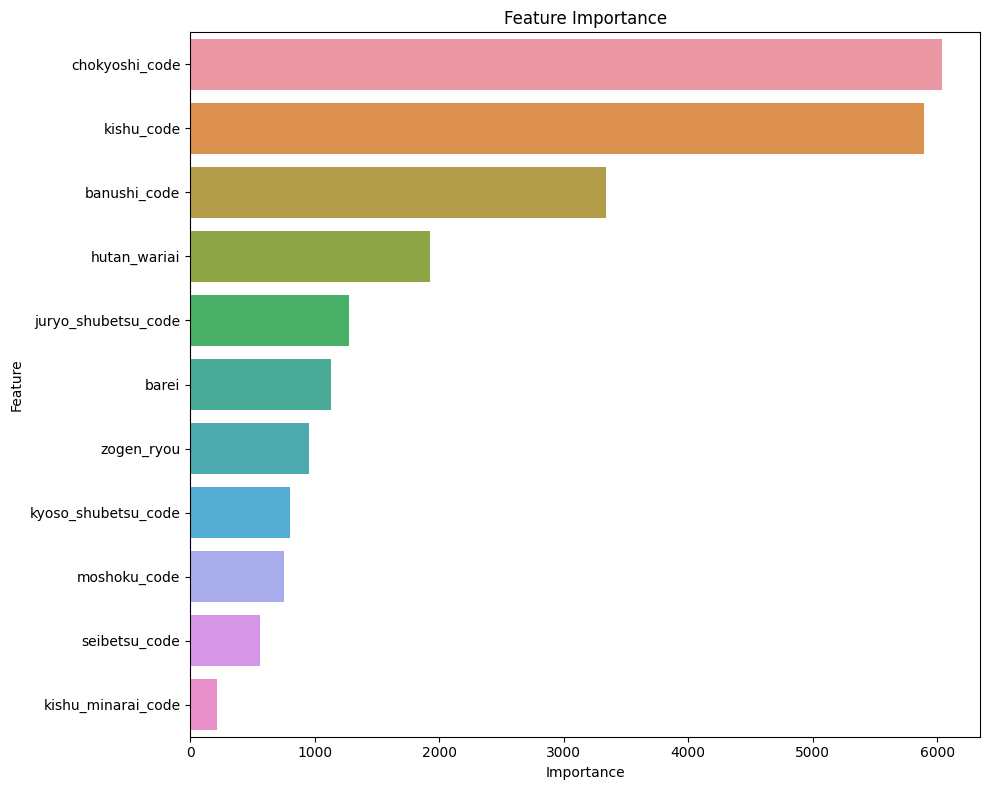

In [27]:
# models[0]'s feature importances
feature_importance = models[0].feature_importances_

# Convert feature names and importances to DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [28]:
test_data = merged_df[merged_df['kaisai_nen'].isin([2020, 2021, 2022])]

In [29]:
test_data.loc[:, 'y_pred'] = sum([model.predict(test_data[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data.loc[:, 'predicted_rank'] = test_data.groupby('group')['y_pred'].rank(method='min')

C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\3736083596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'y_pred'] = sum([model.predict(test_data[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
C:\Users\kawam\AppData\Local\Temp\ipykernel_26524\3736083596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_rank'] = test_data.groupby('group')['y_pred'].rank(method='min')


In [30]:
test_data.to_csv('./tmp/test_data.csv')

In [31]:
test_data = pd.read_csv('./tmp/test_data.csv')

In [32]:
is_correct_df = test_data.groupby('group').apply(check_top3_in_top5_predictions).reset_index(name='is_correct')
profit_df = test_data.groupby('group').apply(calculate_group_profit).reset_index(name='profit')
result_df = is_correct_df.merge(profit_df, on='group', how='left')

NameError: name 'check_top3_in_top5_predictions' is not defined

In [ ]:
result_df = result_df.merge(n_race_df, on='group', how='left')

In [ ]:
result_df.head(1)

In [ ]:
# 月日の変換
result_df['kaisai_tsukihi'] = result_df['kaisai_tsukihi'].astype(str)
result_df['kaisai_month'] = result_df['kaisai_tsukihi'].str[:-2].astype(int)
result_df['kaisai_day'] = result_df['kaisai_tsukihi'].str[-2:].astype(int)

In [ ]:
# 1. 各カテゴリ変数に対する正解率の可視化
for column in ['kaisai_nen', 
               'kaisai_month',
               'kaisai_day',
               'keibajo_code', 
               'kaisai_nichime', 
               'race_bango', 
               'yobi_code', 
               'jusho_kaiji', 
               'grade_code', 
               'kyoso_shubetsu_code', 
               'kyoso_kigo_code',
               'juryo_shubetsu_code',
               'kyoso_joken_code',
               'kyori',
               'track_code',
               'course_kubun',
               'tenko_code',
               'babajotai_code_shiba',
               'babajotai_code_dirt'
              ]:  # ... には他のカテゴリ変数のカラム名を追加
    plt.figure(figsize=(12, 6))
    sns.barplot(x=column, y='is_correct', data=result_df)
    plt.title(f'Correct Rate by {column}')
    plt.ylabel('Correct Rate')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# 2. 各カテゴリ変数に対する平均利益の可視化
for column in ['kaisai_nen', 
               'kaisai_month',
               'kaisai_day',
               'keibajo_code', 
               'kaisai_nichime', 
               'race_bango', 
               'yobi_code', 
               'jusho_kaiji', 
               'grade_code', 
               'kyoso_shubetsu_code', 
               'kyoso_kigo_code',
               'juryo_shubetsu_code',
               'kyoso_joken_code',
               'kyori',
               'track_code',
               'course_kubun',
               'tenko_code',
               'babajotai_code_shiba',
               'babajotai_code_dirt'
              ]: # ... には他のカテゴリ変数のカラム名を追加
    plt.figure(figsize=(12, 6))
    sns.barplot(x=column, y='profit', data=result_df)
    plt.title(f'Average Profit by {column}')
    plt.ylabel('Average Profit')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# 3. 数値変数とprofitの関係を散布図で表示
for column in ['kaisai_tsukihi', 
               'kyori',
               'honshokin', 
               'hasso_jikoku', 
               'toroku_tosu', 
               'shusso_tosu', 
               'nyusen_tosu']:  # ... には他の数値変数のカラム名を追加
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=column, y='profit', data=result_df)
    plt.title(f'Profit vs. {column}')
    plt.ylabel('Profit')
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()

# モデル保存

In [ ]:
# 学習
full_train_dataset = lgb.Dataset(merged_df[features], label=merged_df[target])
full_model = lgb.train(best_params, full_train_dataset, num_boost_round=500, verbose_eval=100)

# モデルを保存
# model_save_path = '../app/models/model.pkl'
model_save_path = './bestmodels/lightgbmranker.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(full_model, f)

print(f"Model saved to {model_save_path}")

In [ ]:
results_2020

In [ ]:
successful_groups_2020